# Introduction

In this notebook, we set out to assess whether the CDR loops of TCRs stay in there canonical forms between *apo* and *holo* states or if they disrupt them.
We first cluster previously generated pair-wise distance matrices of CDR loops, then assign them as canonical or not, before comparing the *apo* and *holo* cluster memberships.

In [1]:
import glob
import os
import itertools
import subprocess
import tempfile

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import logomaker
from ipywidgets import Dropdown, VBox
from IPython.display import display, clear_output
from python_pdb.aligners import align_pandas_structure
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from python_pdb.parsers import parse_pdb_to_pandas
from sklearn.manifold import TSNE

from tcr_pmhc_interface_analysis.processing import annotate_tcr_pmhc_df, find_anchors
from tcr_pmhc_interface_analysis.utils import get_coords

In [2]:
DATA_DIR = '../data/interim/structure-pw-distances'

In [3]:
with open(os.path.join(DATA_DIR, 'structure_names.txt'), 'r') as fh:
    structure_names = [line.strip() for line in fh.readlines()]

# Clustering loop conformations

In [4]:
df = pd.DataFrame()

for path in glob.glob(os.path.join(DATA_DIR, '*_distance_matrix.txt*')):
    name = os.path.basename(path).split('.')[0].replace('_distance_matrix', '')

    cdr, chain = name.split('_')

    cdr_distance_matrix = np.loadtxt(path)

    cdr_clusters = hdbscan.HDBSCAN(min_cluster_size=5, metric='precomputed').fit_predict(cdr_distance_matrix)

    cdr_tsne = TSNE(metric='precomputed').fit_transform(cdr_distance_matrix)

    cdr_df = pd.DataFrame({
        'name': structure_names,
        'cluster': cdr_clusters,
        'tsne_1': cdr_tsne[:, 0],
        'tsne_2': cdr_tsne[:, 1],
    })
    cdr_df['chain_type'] = chain + '_chain'
    cdr_df['cdr'] = cdr.replace('cdr', '')

    df = pd.concat([df, cdr_df])

df

/home/b/bmcmaste/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/b/bmcmaste/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/b/bmcmaste/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/b/bmcmaste/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/b/bmcmaste/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/b/bmcmaste/.local/lib/pyt

name  cluster     tsne_1     tsne_2   chain_type cdr
0    7zt2_DE       10  -6.662935 -11.699855   beta_chain   2
1    7zt3_DE       10  -5.507317 -10.976900   beta_chain   2
2    7zt4_DE       10  -6.258807 -11.679200   beta_chain   2
3    7zt5_DE       10  -6.517498 -11.380506   beta_chain   2
4    7zt7_DE       10  -5.995350 -12.048505   beta_chain   2
..       ...      ...        ...        ...          ...  ..
797  6miv_CD       13  50.828583  10.008550  alpha_chain   3
798  3rtq_CD       13  53.744499  15.734530  alpha_chain   3
799  3dxa_NO        6  29.015490 -10.060468  alpha_chain   3
800  1d9k_AB       -1  15.722201   0.155869  alpha_chain   3
801  4gg6_GH       -1  30.463139 -13.151018  alpha_chain   3

[4812 rows x 6 columns]

In [5]:
df['cluster'] = df['cluster'].apply(str)
df['cluster'] = df['cluster'].replace('-1', 'noise')

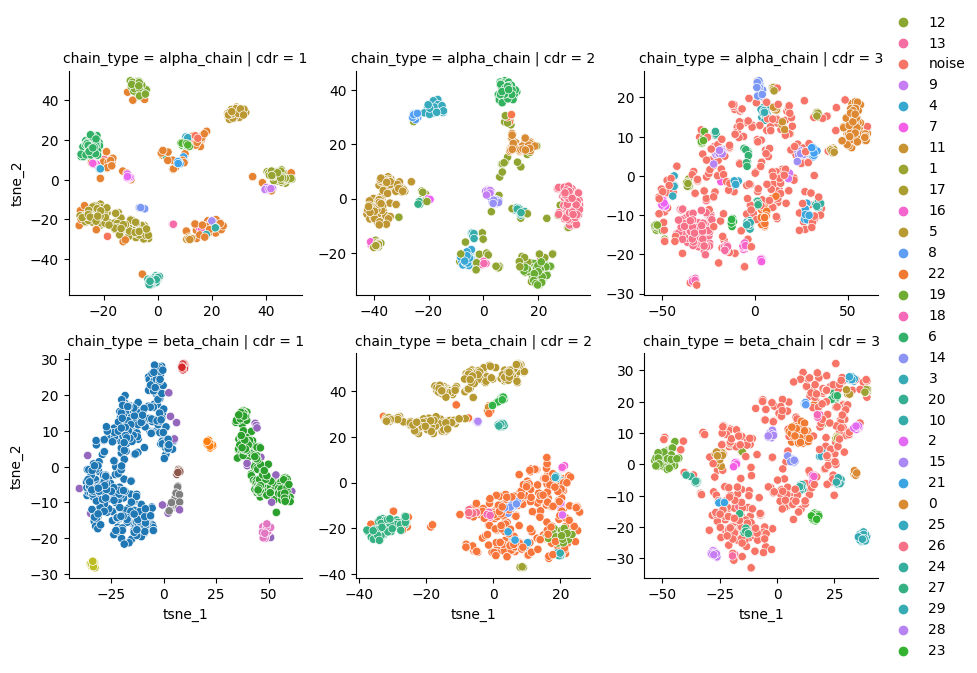

In [6]:
g = sns.FacetGrid(df.sort_values(['chain_type', 'cdr']), row='chain_type', col='cdr', sharex=False, sharey=False)
g.map(sns.scatterplot, 'tsne_1', 'tsne_2', 'cluster')
g.add_legend()

In [7]:
df.groupby(['chain_type', 'cdr'])['cluster'].value_counts()

chain_type   cdr  cluster
alpha_chain  1    7          187
                  noise      137
                  16          80
                  11          62
                  1           58
                            ... 
beta_chain   3    17           6
                  21           6
                  25           6
                  8            6
                  16           5
Name: cluster, Length: 129, dtype: int64

# Add sequences for each loop

In [8]:
structures = pd.DataFrame({
    'name': df['name'].unique(),
})

structures

name
0    7zt2_DE
1    7zt3_DE
2    7zt4_DE
3    7zt5_DE
4    7zt7_DE
..       ...
797  6miv_CD
798  3rtq_CD
799  3dxa_NO
800  1d9k_AB
801  4gg6_GH

[802 rows x 1 columns]

In [9]:
structures[['pdb_id', 'chains']] = structures['name'].str.split('_').apply(pd.Series)
structures[['alpha_chain_id', 'beta_chain_id']] = structures['chains'].apply(list).apply(pd.Series)

structures

name pdb_id chains alpha_chain_id beta_chain_id
0    7zt2_DE   7zt2     DE              D             E
1    7zt3_DE   7zt3     DE              D             E
2    7zt4_DE   7zt4     DE              D             E
3    7zt5_DE   7zt5     DE              D             E
4    7zt7_DE   7zt7     DE              D             E
..       ...    ...    ...            ...           ...
797  6miv_CD   6miv     CD              C             D
798  3rtq_CD   3rtq     CD              C             D
799  3dxa_NO   3dxa     NO              N             O
800  1d9k_AB   1d9k     AB              A             B
801  4gg6_GH   4gg6     GH              G             H

[802 rows x 5 columns]

In [10]:
def get_sequence(df):
    residue_names = df.drop_duplicates(['chain_id', 'residue_seq_id', 'residue_insert_code'])['residue_name']
    return ''.join(residue_names.map(THREE_TO_ONE_CODE).tolist())

In [11]:
def get_cdr_sequences(pdb_id, alpha_chain_id, beta_chain_id):
    with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
        structure_df = parse_pdb_to_pandas(fh.read())

    structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
    tcr_df = structure_df.query('chain_type.notnull()')

    cdr_sequences = tcr_df.groupby(['chain_type', 'cdr']).apply(get_sequence)
    cdr_sequences.name = 'sequence'

    index = cdr_sequences.index.to_flat_index()
    index = index.map(lambda index: f"cdr_{'a' if index[0] == 'alpha_chain' else 'b'}{int(index[1])}_sequence")
    cdr_sequences.index = index

    return cdr_sequences

In [12]:
structures = pd.concat([structures,
                        structures.apply(
                            lambda row: get_cdr_sequences(row.pdb_id, row.alpha_chain_id, row.beta_chain_id),
                            axis=1,
                        )],
                        axis=1)

structures

name pdb_id chains alpha_chain_id beta_chain_id cdr_a1_sequence  \
0    7zt2_DE   7zt2     DE              D             E          TSGFNG   
1    7zt3_DE   7zt3     DE              D             E          TSGFNG   
2    7zt4_DE   7zt4     DE              D             E          TSGFNG   
3    7zt5_DE   7zt5     DE              D             E          TSGFNG   
4    7zt7_DE   7zt7     DE              D             E          TSGFNG   
..       ...    ...    ...            ...           ...             ...   
797  6miv_CD   6miv     CD              C             D          VTPDNH   
798  3rtq_CD   3rtq     CD              C             D          VTPDNH   
799  3dxa_NO   3dxa     NO              N             O         TISGNEY   
800  1d9k_AB   1d9k     AB              A             B          DSTFDY   
801  4gg6_GH   4gg6     GH              G             H         TISGTDY   

    cdr_a2_sequence cdr_a3_sequence cdr_b1_sequence cdr_b2_sequence  \
0            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
1            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
2            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
3            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
4            NVLDGL      AFLDSNYQLI           MNHNY          SASEGT   
..              ...             ...             ...             ...   
797         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
798         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
799           GLKNN      IVWGGYQKVT           SEHNR          FQNEAQ   
800         ISLVSNK      AATGSFNKLT           NNHNN          SYGAGS   
801           GLTSN   ILRDGRGGADGLT           SGDLS          YYNGEE   

    cdr_b3_sequence  
0       ASSNREYSPLH  
1       ASSNREYSPLH  
2       ASSNREYSPLH  
3       ASSNREYSPLH  
4       ASSNREYSPLH  
..              ...  
797      ASGDEGYTQY  
798      ASGDEGYTQY  
799   ASRYRDDSYNEQF  
800     ASGGQGRAEQF  
801  ASSVAVSAGTYEQY  

[802 rows x 11 columns]

In [13]:
structures = structures.melt(id_vars=['name'],
                             value_vars=['cdr_a1_sequence',
                                         'cdr_a2_sequence',
                                         'cdr_a3_sequence',
                                         'cdr_b1_sequence',
                                         'cdr_b2_sequence',
                                         'cdr_b3_sequence'],
                            value_name='sequence')

In [14]:
structures[['chain_type', 'cdr']] = structures['variable'].map(lambda name: tuple(name.split('_')[1])).apply(pd.Series)
structures['chain_type'] = structures['chain_type'].map(lambda letter: 'alpha_chain' if letter == 'a' else 'beta_chain')

structures

name         variable        sequence   chain_type cdr
0     7zt2_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
1     7zt3_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
2     7zt4_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
3     7zt5_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
4     7zt7_DE  cdr_a1_sequence          TSGFNG  alpha_chain   1
...       ...              ...             ...          ...  ..
4807  6miv_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4808  3rtq_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4809  3dxa_NO  cdr_b3_sequence   ASRYRDDSYNEQF   beta_chain   3
4810  1d9k_AB  cdr_b3_sequence     ASGGQGRAEQF   beta_chain   3
4811  4gg6_GH  cdr_b3_sequence  ASSVAVSAGTYEQY   beta_chain   3

[4812 rows x 5 columns]

In [15]:
df = df.merge(structures[['name', 'chain_type', 'cdr', 'sequence']],
             how='left',
             on=['name', 'chain_type', 'cdr'])

# Adding cannonical conformation information to clusters

Based on the definition from [Comparative Analysis of the CDR Loops of Antigen Receptors](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.02454/full), canonical clusters are any cluster where there are more than two unique sequences within the density clusters. The other clusters will be refered to as pseudo-clusters, as these may just be the effect of the same loop finding the same conformation.

In [16]:
cluster_types = df.query("cluster != 'noise'").groupby(
    ['chain_type', 'cdr', 'cluster'],
)['sequence'].agg(lambda sequences: 'canonical' if sequences.nunique() > 2 else 'pseudo')
cluster_types.name = 'cluster_type'

In [17]:
cluster_types[cluster_types == 'canonical'].reset_index().sort_values(['chain_type', 'cdr']).value_counts(['chain_type', 'cdr'])

chain_type   cdr
alpha_chain  3      13
             2       9
beta_chain   3       9
alpha_chain  1       7
beta_chain   1       4
             2       4
dtype: int64

In [18]:
df = df.merge(cluster_types.reset_index(), how='left', on=['chain_type', 'cdr', 'cluster'])

## Do the canonical clusters exist across different loop lengths?

In [19]:
df['cdr_length'] = df['sequence'].map(len)

In [20]:
df.groupby(['chain_type', 'cdr', 'cluster'])['cdr_length'].describe()

count       mean       std   min   25%   50%   75%  \
chain_type  cdr cluster                                                       
alpha_chain 1   0          7.0   5.000000  0.000000   5.0   5.0   5.0   5.0   
                1         58.0   7.000000  0.000000   7.0   7.0   7.0   7.0   
                10        16.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
                11        62.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
                12         7.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
...                        ...        ...       ...   ...   ...   ...   ...   
beta_chain  3   6         11.0  12.000000  0.000000  12.0  12.0  12.0  12.0   
                7          7.0  13.000000  0.000000  13.0  13.0  13.0  13.0   
                8          6.0  12.000000  0.000000  12.0  12.0  12.0  12.0   
                9         11.0  12.000000  0.000000  12.0  12.0  12.0  12.0   
                noise    444.0  11.878378  1.777355   6.0  11.0  12.0  13.0   

                          max  
chain_type  cdr cluster        
alpha_chain 1   0         5.0  
                1         7.0  
                10        6.0  
                11        6.0  
                12        6.0  
...                       ...  
beta_chain  3   6        12.0  
                7        13.0  
                8        12.0  
                9        12.0  
                noise    18.0  

[129 rows x 8 columns]

Some clustering with different lengths!

# Visualizing the canonical cluster structures and sequences

## Sequence motifs for each canonical cluster

In [21]:
def format_fasta(group):
    index = group.index.tolist()
    sequence = group['sequence'].tolist()

    fasta = []

    for idx, sequence in zip(index, sequence):
        fasta.append(f'>{idx}\n{sequence}')

    return '\n'.join(fasta)

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


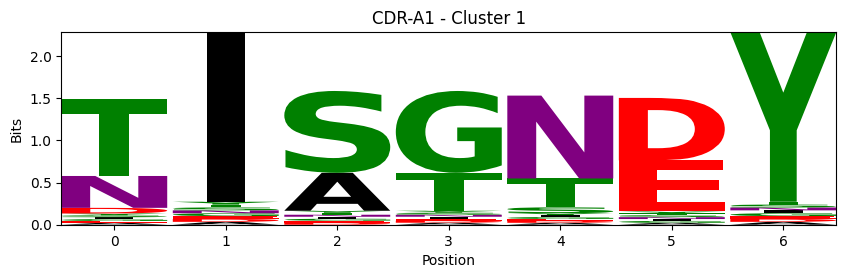

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


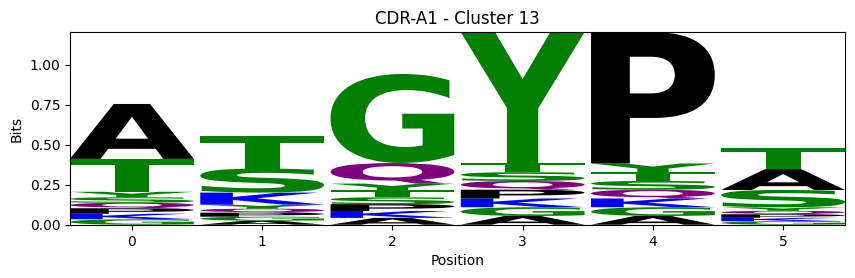

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


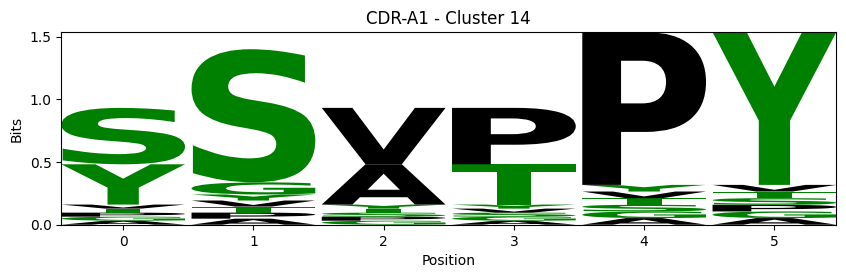

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


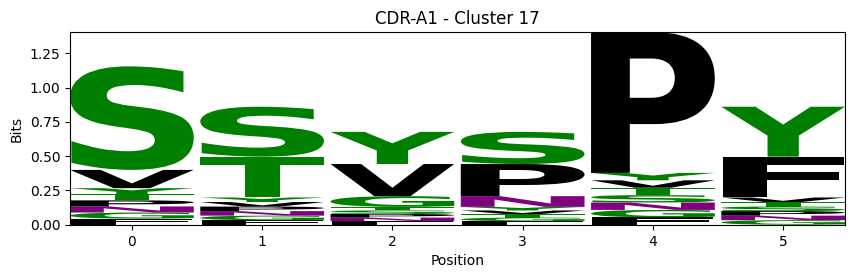

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


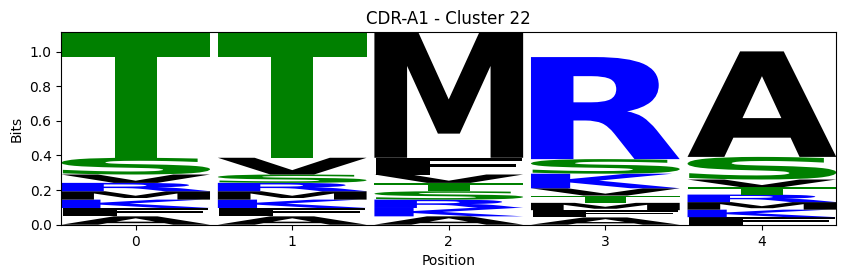

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


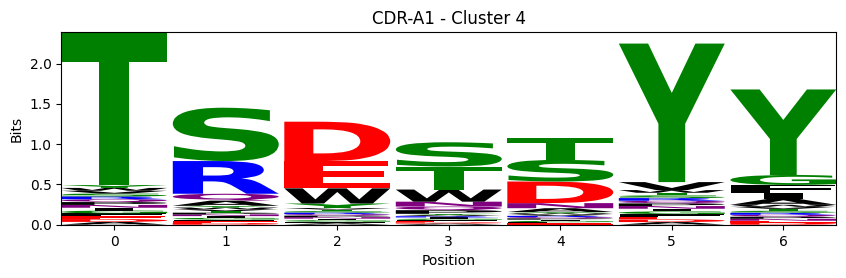

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


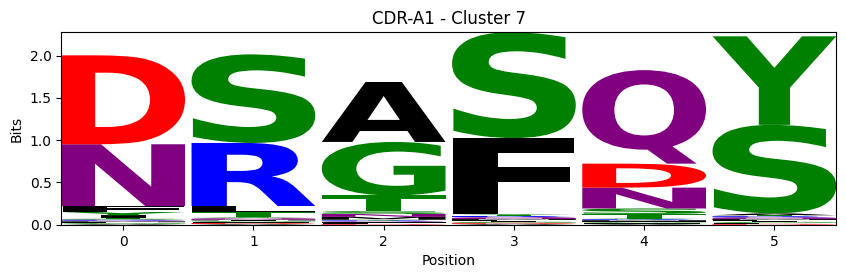

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


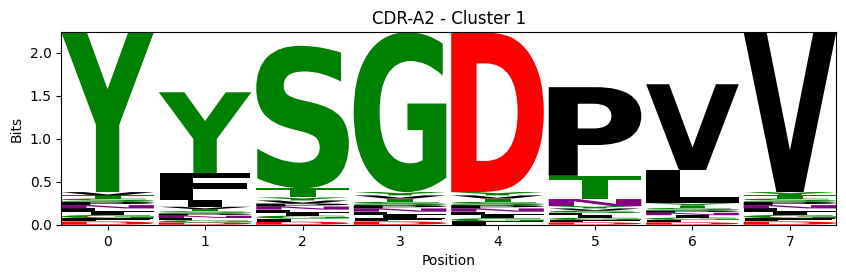

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


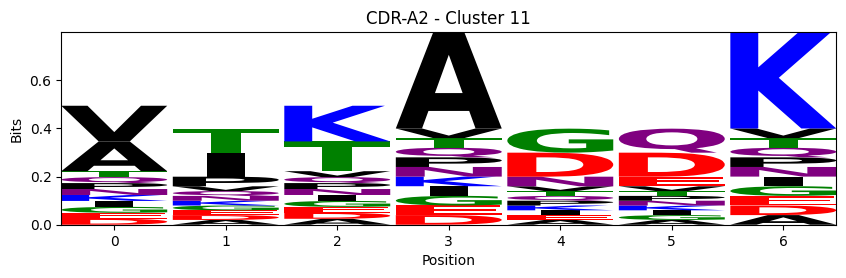

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


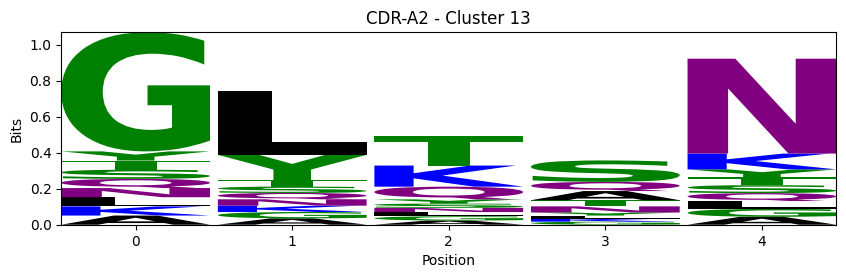

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


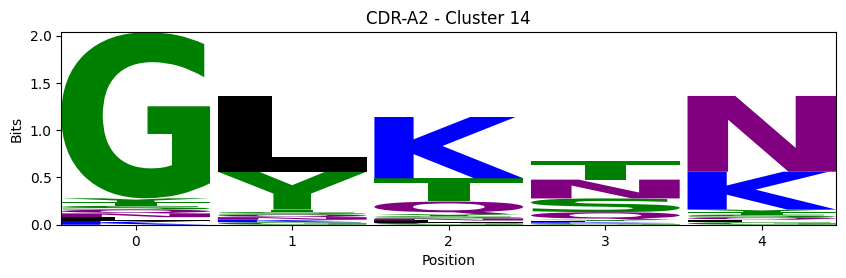

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


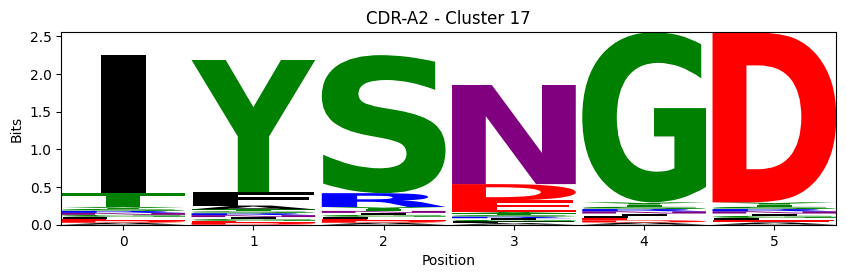

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


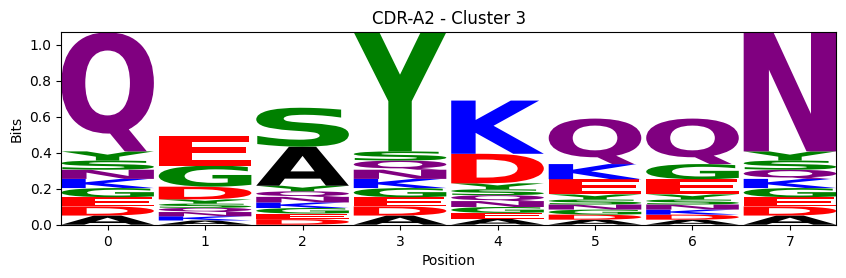

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


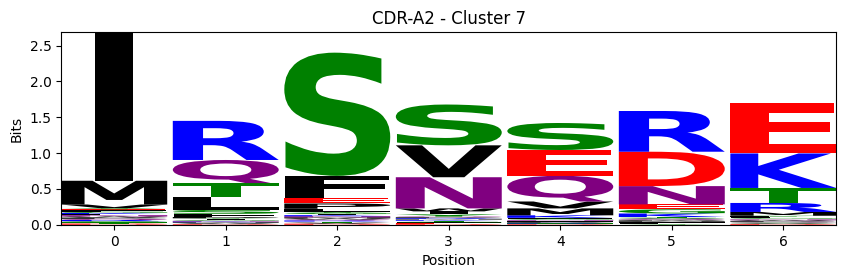

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


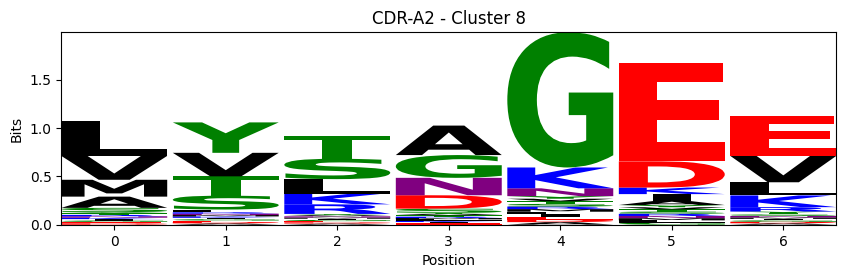

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


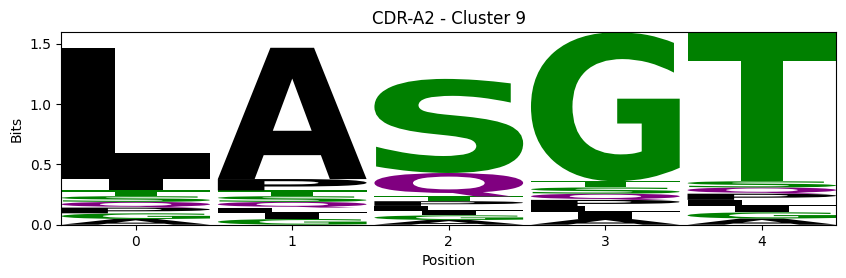

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


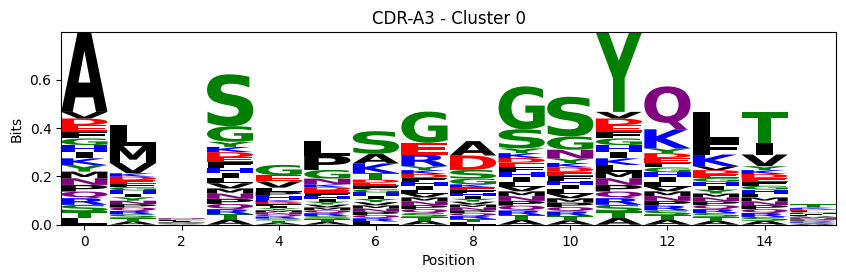

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


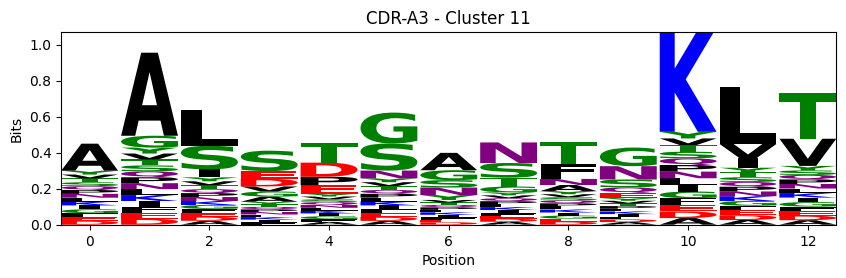

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


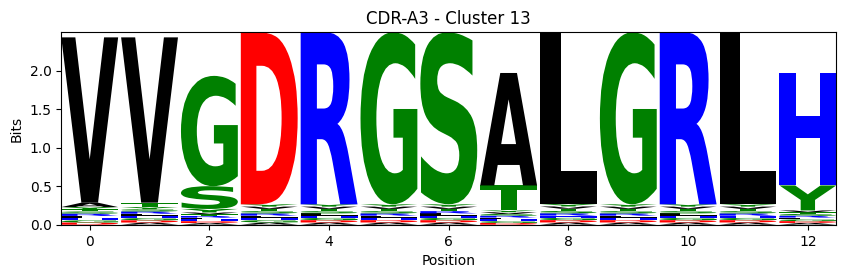

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


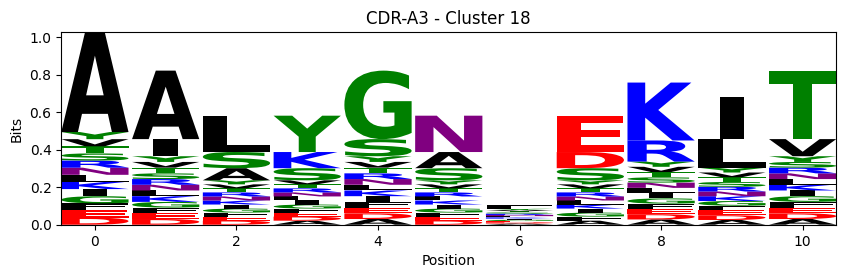

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


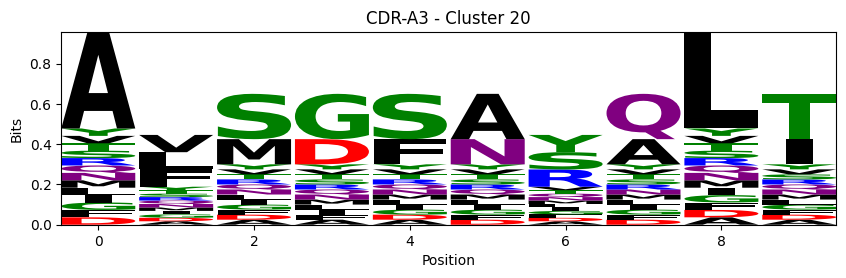

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


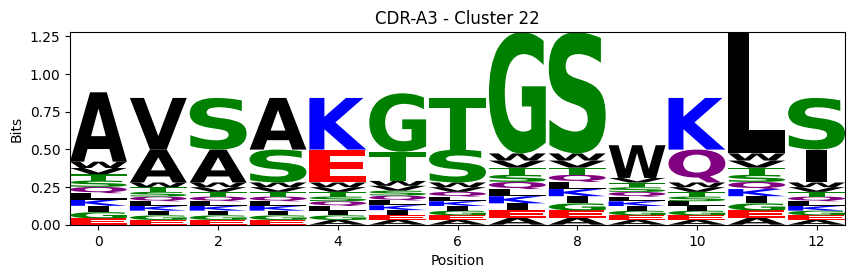

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


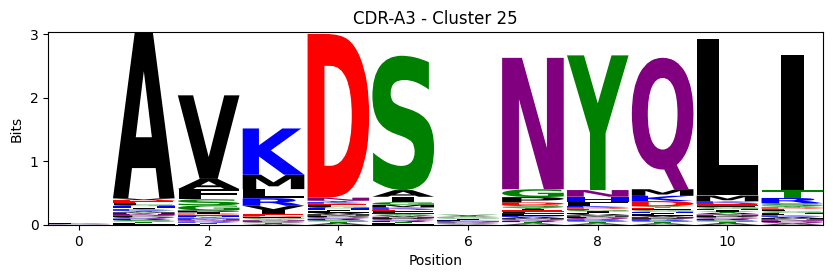

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


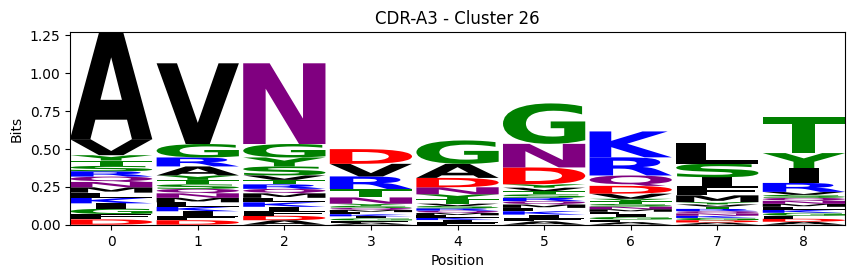

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


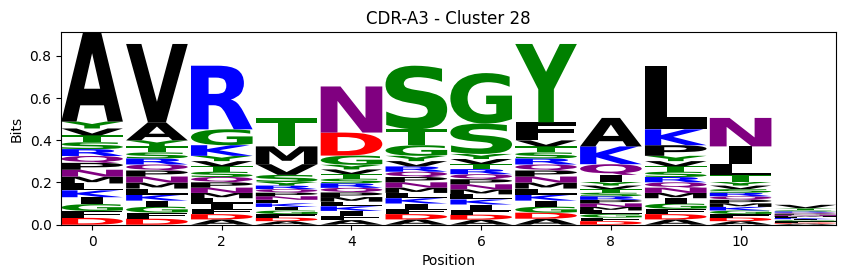

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


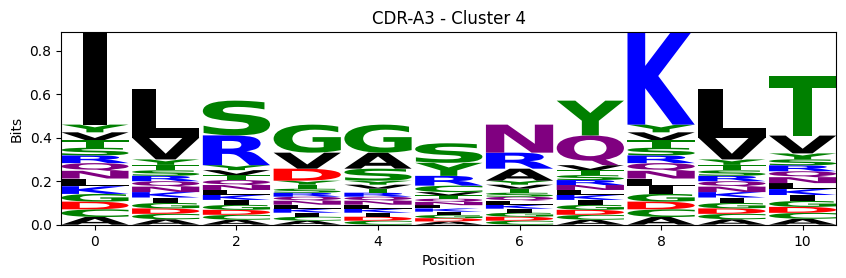

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


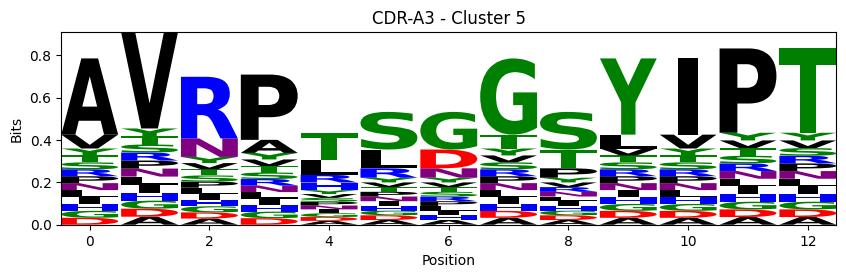

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


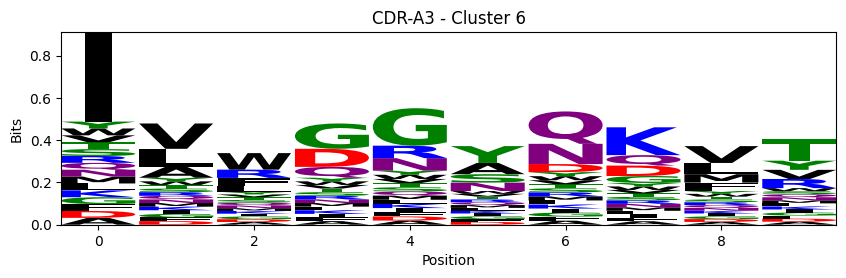

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


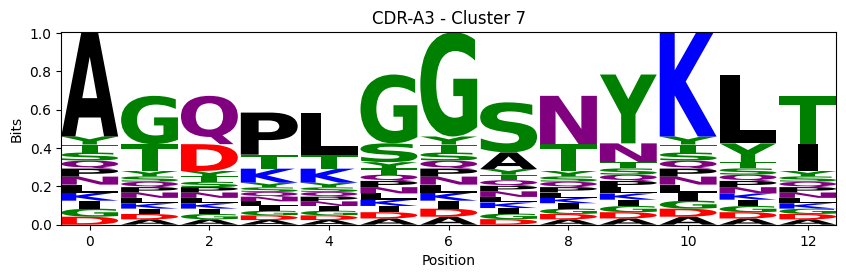

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


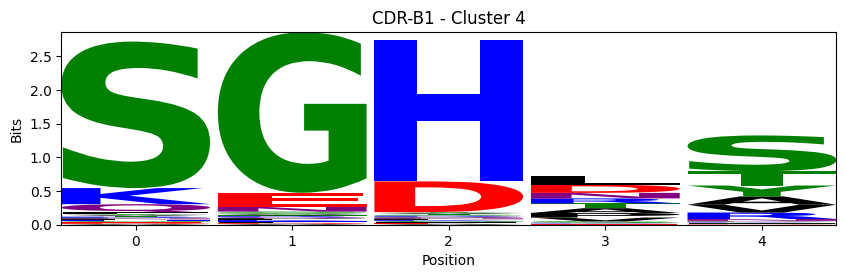

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


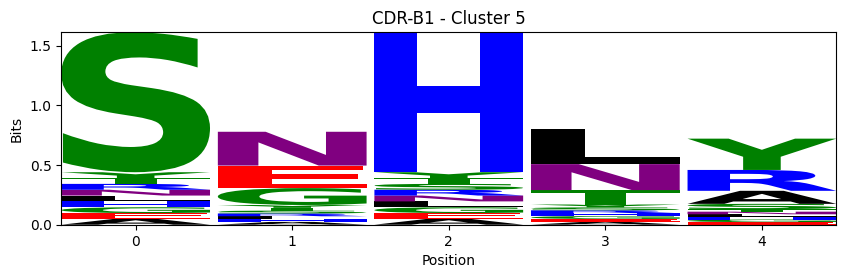

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


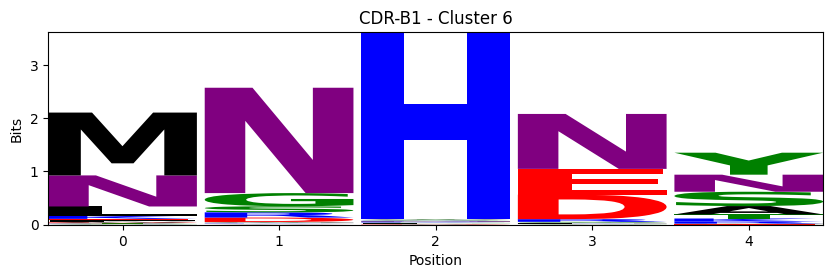

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


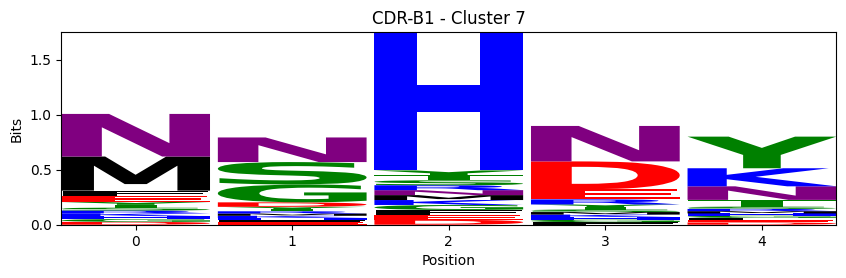

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


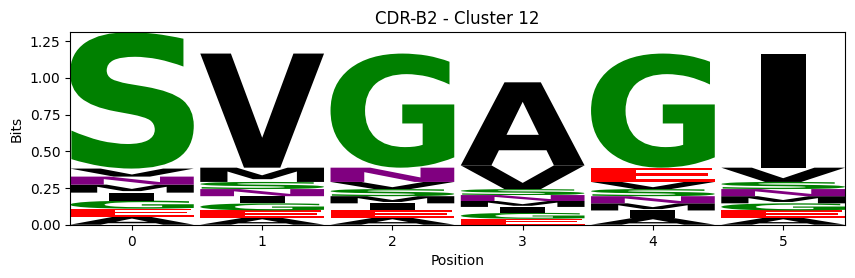

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


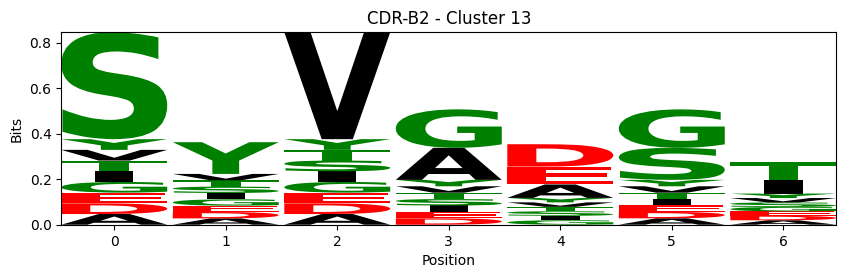

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


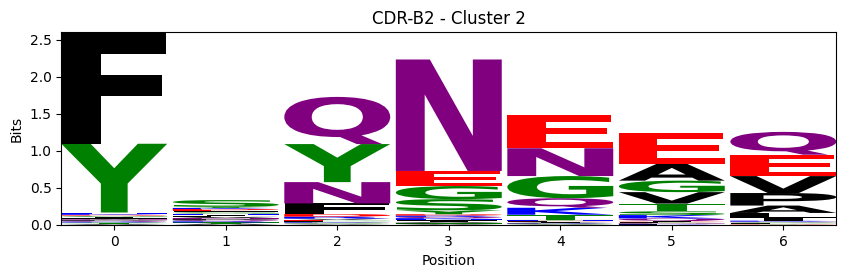

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


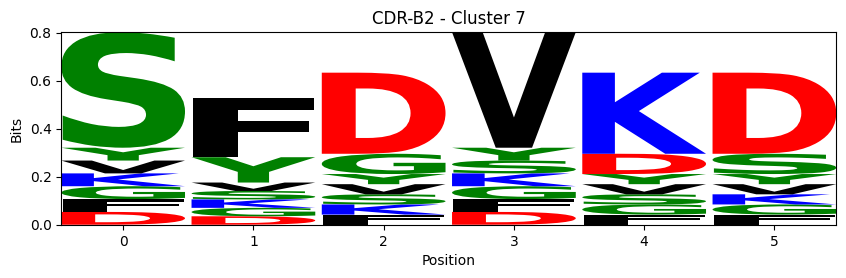

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


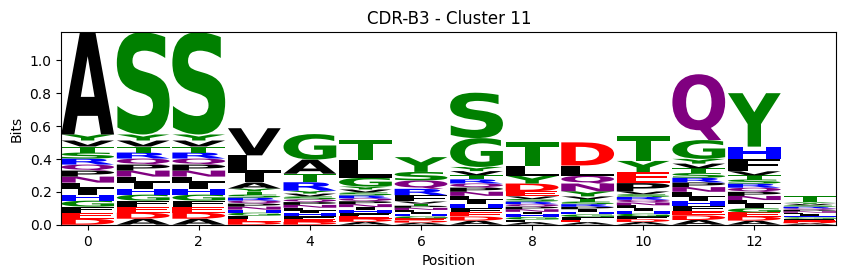

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


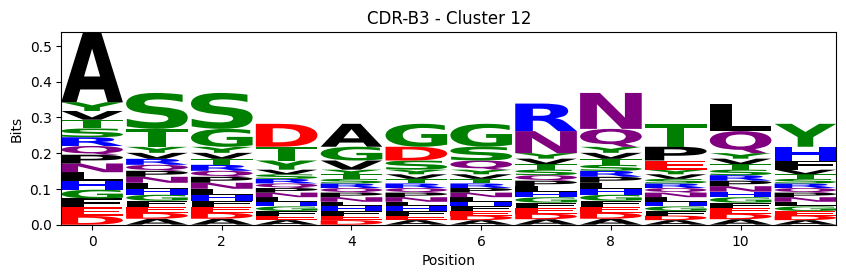

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


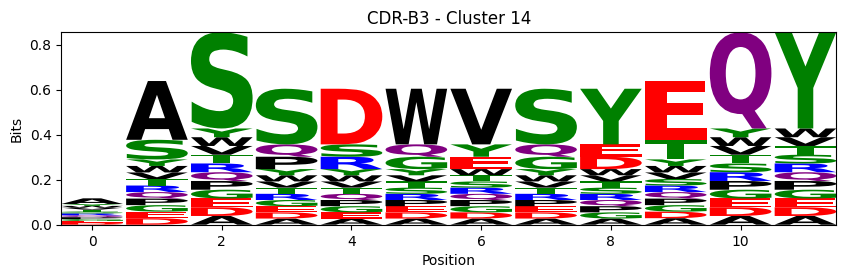

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


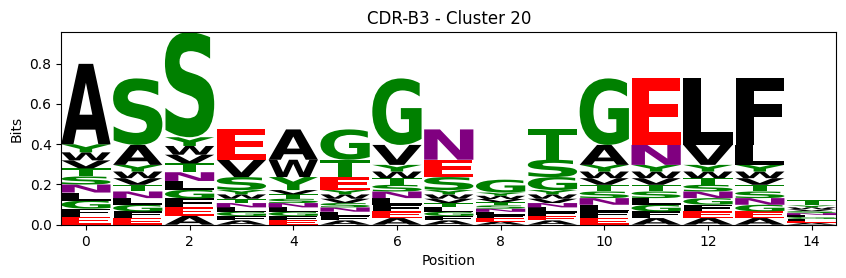

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


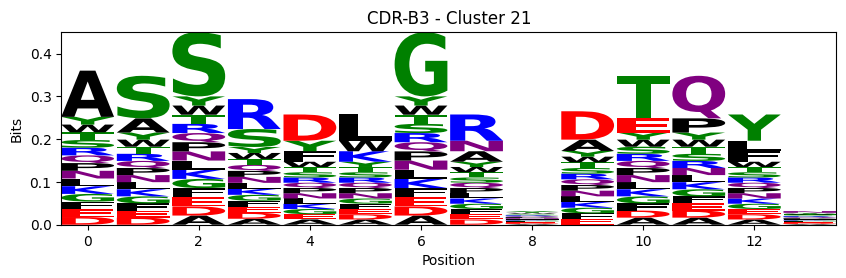

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


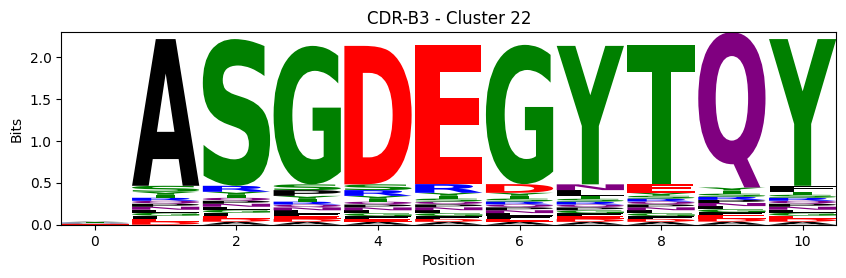

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


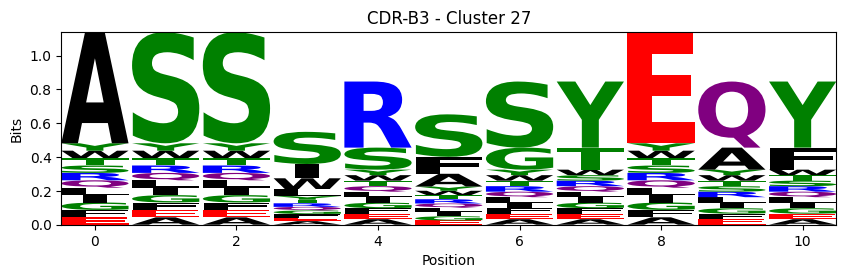

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


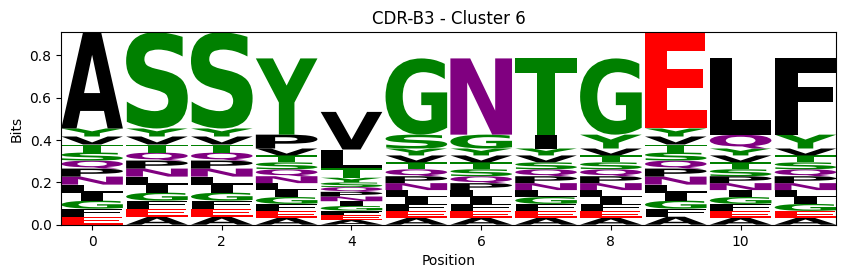

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


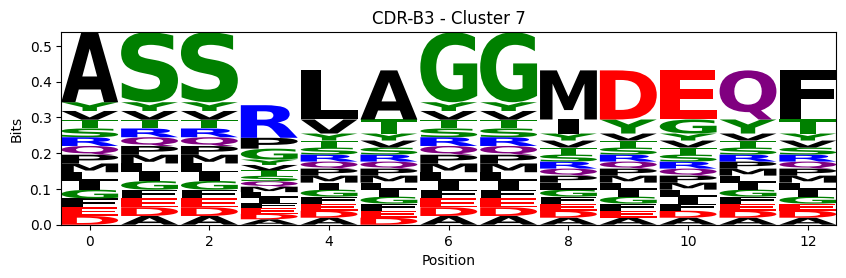

In [22]:
for (chain_type, cdr, cluster), group in (df.query("cluster != 'noise' and cluster_type == 'canonical'")
                                            .groupby(['chain_type', 'cdr', 'cluster'])):
    with tempfile.TemporaryDirectory() as directory:
        input_file = os.path.join(directory, 'input.fasta')
        output_file = os.path.join(directory, 'output.fasta')

        with open(input_file, 'w') as fh:
            fh.write(format_fasta(group))

        cmd = f'clustalw2 -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA'
        subprocess.run(cmd.split(), check=True, stdout=subprocess.DEVNULL)

        with open(output_file, 'r') as fh:
            aligned_sequences = [line.strip() for line in fh.readlines() if not line.startswith('>')]


    probs = logomaker.alignment_to_matrix(aligned_sequences, to_type='information')
    logomaker.Logo(probs, color_scheme='chemistry')

    cluster_name = f"CDR-{'A' if chain_type == 'alpha_chain' else 'B'}{cdr} - Cluster {cluster}"

    plt.title(cluster_name)
    plt.ylabel('Bits')
    plt.xlabel('Position')

    plt.savefig(f'../report/figures/cdr-loop-clusters/logo_plots/{cluster_name}.svg')
    plt.show()

## Look at backbone traces of each cluster

In [23]:
ca_coordinates = []
names = []
chain_types = []
cdrs = []
clusters = []

for (chain_type, cdr, cluster), group in (df.query("cluster != 'noise' and cluster_type == 'canonical'")
                                            .groupby(['chain_type', 'cdr', 'cluster'])):
    pdb_id, chains = group.iloc[0]['name'].split('_')
    alpha_chain_id, beta_chain_id = tuple(chains)
    cdr = int(cdr)

    with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
        reference_structure_df = parse_pdb_to_pandas(fh.read())

    reference_structure_df = annotate_tcr_pmhc_df(reference_structure_df, alpha_chain_id, beta_chain_id)
    reference_tcr_df = reference_structure_df.query('chain_type.notnull()')

    reference_cdr_df = reference_tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
    refrence_anchors = pd.concat(find_anchors(reference_cdr_df, reference_tcr_df, 5))

    for _, row in group.iterrows():
        pdb_id, chains = row['name'].split('_')
        alpha_chain_id, beta_chain_id = tuple(chains)

        chain_type = row.chain_type
        cdr = int(row.cdr)

        with open(os.path.join('../data/raw/stcrdab', 'imgt', pdb_id + '.pdb'), 'r') as fh:
            structure_df = parse_pdb_to_pandas(fh.read())

        structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
        tcr_df = structure_df.query('chain_type.notnull()')

        cdr_df = tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
        anchors = pd.concat(find_anchors(cdr_df, tcr_df, 5))

        cdr_df = align_pandas_structure(
            get_coords(anchors.query("atom_name == 'N' or atom_name == 'C' or atom_name == 'CA' or atom_name == 'O'")),
            get_coords(refrence_anchors.query(("atom_name == 'N' or atom_name == 'C' "
                                               "or atom_name == 'CA' or atom_name == 'O'"))),
            cdr_df,
        )

        coords = get_coords(cdr_df.query("atom_name == 'CA'"))

        ca_coordinates.append(coords)
        chain_types.append(chain_type)
        cdrs.append(cdr)
        clusters.append(cluster)
        names.append(row['name'])

ca_coordinate_df = pd.DataFrame({
    'ca_coordinate': ca_coordinates,
    'chain_type': chain_types,
    'cdr': cdrs,
    'name': names,
    'cluster': clusters,
})

ca_coordinate_df = ca_coordinate_df.explode('ca_coordinate')
ca_coordinate_df[['ca_coordinate_x',
                  'ca_coordinate_y',
                  'ca_coordinate_z']] = ca_coordinate_df['ca_coordinate'].apply(pd.Series)
ca_coordinate_df = ca_coordinate_df.drop('ca_coordinate', axis=1)
ca_coordinate_df

chain_type  cdr     name cluster  ca_coordinate_x  ca_coordinate_y  \
0     alpha_chain    1  4ozg_EF       1       224.155000        40.712000   
0     alpha_chain    1  4ozg_EF       1       227.900000        39.718000   
0     alpha_chain    1  4ozg_EF       1       229.249000        39.147000   
0     alpha_chain    1  4ozg_EF       1       232.636000        40.071000   
0     alpha_chain    1  4ozg_EF       1       234.200000        36.568000   
...           ...  ...      ...     ...              ...              ...   
2245   beta_chain    3  3gsn_AB       7       -55.580629        12.969075   
2245   beta_chain    3  3gsn_AB       7       -56.991148        13.552541   
2245   beta_chain    3  3gsn_AB       7       -55.012334        12.367820   
2245   beta_chain    3  3gsn_AB       7       -53.256231        14.847797   
2245   beta_chain    3  3gsn_AB       7       -54.906846        15.594755   

      ca_coordinate_z  
0          219.187000  
0          219.665000  
0          223.257000  
0          224.817000  
0          224.708000  
...               ...  
2245        -2.638147  
2245        -6.135106  
2245        -9.171847  
2245       -11.441973  
2245       -14.752955  

[15537 rows x 7 columns]

In [24]:
ca_coordinate_df['cluster_name'] = (
    'CDR-'
    + ca_coordinate_df['chain_type'].map(lambda chain_type: 'A' if chain_type == 'alpha_chain' else 'B')
    + ca_coordinate_df['cdr'].apply(str)
    + ' - Cluster '
    + ca_coordinate_df['cluster']
)

In [25]:
for cluster_name, cluster_df in ca_coordinate_df.groupby('cluster_name'):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.write_html(f"../report/figures/cdr-loop-clusters/backbone_traces/{cluster_name}.html")

In [26]:
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)

        dropdown = Dropdown(options=cluster_names, description='Select Cluster')
        dropdown.observe(on_change)
        display(VBox([dropdown]))

        plot_cluster(change['new'])

def plot_cluster(cluster_name):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.show()

cluster_names = ca_coordinate_df['cluster_name'].unique().tolist()

dropdown = Dropdown(options=cluster_names, description='Select Cluster')
dropdown.observe(on_change)
display(VBox([dropdown]))

plot_cluster(cluster_names[0])

# Compare *apo* and *holo* forms of loops

In [27]:
apo_holo_summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')
apo_holo_summary_df

file_name pdb_id structure_type state alpha_chain  \
0    1ao7_D-E-C-A-B_tcr_pmhc.pdb   1ao7       tcr_pmhc  holo           D   
1    1bd2_D-E-C-A-B_tcr_pmhc.pdb   1bd2       tcr_pmhc  holo           D   
2            1bii_A-B-P_pmhc.pdb   1bii           pmhc   apo         NaN   
3            1ddh_A-B-P_pmhc.pdb   1ddh           pmhc   apo         NaN   
4            1duz_A-B-C_pmhc.pdb   1duz           pmhc   apo         NaN   
..                           ...    ...            ...   ...         ...   
353  8gon_D-E-C-A-B_tcr_pmhc.pdb   8gon       tcr_pmhc  holo           D   
354             8gop_A-B_tcr.pdb   8gop            tcr   apo           A   
355  8gvb_A-B-P-H-L_tcr_pmhc.pdb   8gvb       tcr_pmhc  holo           A   
356  8gvg_A-B-P-H-L_tcr_pmhc.pdb   8gvg       tcr_pmhc  holo           A   
357  8gvi_A-B-P-H-L_tcr_pmhc.pdb   8gvi       tcr_pmhc  holo           A   

    beta_chain antigen_chain mhc_chain1 mhc_chain2  \
0            E             C          A          B   
1            E             C          A          B   
2          NaN             P          A          B   
3          NaN             P          A          B   
4          NaN             C          A          B   
..         ...           ...        ...        ...   
353          E             C          A          B   
354          B           NaN        NaN        NaN   
355          B             P          H          L   
356          B             P          H          L   
357          B             P          H          L   

                                cdr_sequences_collated peptide_sequence  \
0    DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...        LLFGYPVYV   
1    NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...        LLFGYPVYV   
2                                                  NaN       RGPGRAFVTI   
3                                                  NaN       RGPGRAFVTI   
4                                                  NaN        LLFGYPVYV   
..                                                 ...              ...   
353  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...              NaN   
354  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...              NaN   
355  YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...         RYPLTFGW   
356  YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...         RFPLTFGW   
357  YGATPY-YFSGDTLV-AVVFTGGGNKLT-SEHNR-FQNEAQ-ASSL...         RYPLTFGW   

        mhc_slug  
0    hla_a_02_01  
1    hla_a_02_01  
2          h2_dd  
3          h2_dd  
4    hla_a_02_01  
..           ...  
353          NaN  
354          NaN  
355  hla_a_24_02  
356  hla_a_24_02  
357  hla_a_24_02  

[358 rows x 12 columns]

In [28]:
df[['pdb_id', 'chains']] = df['name'].str.split('_').apply(pd.Series)
df[['alpha_chain', 'beta_chain']] = df['chains'].apply(list).apply(pd.Series)

In [29]:
apo_holo_clusters = df.merge(apo_holo_summary_df,
                             how='inner',
                             on=['pdb_id', 'alpha_chain', 'beta_chain'])
apo_holo_clusters

name cluster     umap_1     umap_2   chain_type cdr       sequence  \
0     8gom_DE       2  -4.930258   3.430283   beta_chain   2         FNNNVP   
1     8gom_DE       4   3.757300  19.753962   beta_chain   1          SGHNS   
2     8gom_DE   noise   9.780348   6.621727   beta_chain   3  ASTWGRASTDTQY   
3     8gom_DE       4  -6.051037  -5.418285  alpha_chain   1        TSESDYY   
4     8gom_DE       3  -7.378064  -8.119769  alpha_chain   2       QEAYKQQN   
...       ...     ...        ...        ...          ...  ..            ...   
1189  3dxa_NO       4   7.103796  18.845861   beta_chain   1          SEHNR   
1190  3dxa_NO   noise   8.999367  -0.035359   beta_chain   3  ASRYRDDSYNEQF   
1191  3dxa_NO       1  11.305151  -8.944687  alpha_chain   1        TISGNEY   
1192  3dxa_NO   noise -15.595358   6.060057  alpha_chain   2          GLKNN   
1193  3dxa_NO       6   9.017627   3.988981  alpha_chain   3     IVWGGYQKVT   

     cluster_type  cdr_length pdb_id  ... beta_chain  \
0       canonical           6   8gom  ...          E   
1       canonical           5   8gom  ...          E   
2             NaN          13   8gom  ...          E   
3       canonical           7   8gom  ...          E   
4       canonical           8   8gom  ...          E   
...           ...         ...    ...  ...        ...   
1189    canonical           5   3dxa  ...          O   
1190          NaN          13   3dxa  ...          O   
1191    canonical           7   3dxa  ...          O   
1192          NaN           5   3dxa  ...          O   
1193    canonical          10   3dxa  ...          O   

                        file_name structure_type state antigen_chain  \
0     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
1     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
2     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
3     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
4     8gom_D-E-C-A-B_tcr_pmhc.pdb       tcr_pmhc  holo             C   
...                           ...            ...   ...           ...   
1189  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1190  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1191  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1192  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   
1193  3dxa_N-O-M-K-L_tcr_pmhc.pdb       tcr_pmhc  holo             M   

     mhc_chain1 mhc_chain2                             cdr_sequences_collated  \
0             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
1             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
2             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
3             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
4             A          B  TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...   
...         ...        ...                                                ...   
1189          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1190          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1191          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1192          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   
1193          K          L  TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDS...   

     peptide_sequence mhc_slug  
0                 NaN      NaN  
1                 NaN      NaN  
2                 NaN      NaN  
3                 NaN      NaN  
4                 NaN      NaN  
...               ...      ...  
1189              NaN      NaN  
1190              NaN      NaN  
1191              NaN      NaN  
1192              NaN      NaN  
1193              NaN      NaN  

[1194 rows x 22 columns]

In [30]:
def collate_clusters(group):
    apo_clusters = sorted(group.query("state == 'apo'")['cluster'].tolist())
    holo_clusters = sorted(group.query("state == 'holo'")['cluster'].tolist())

    return pd.Series({'apo_clusters': apo_clusters, 'holo_clusters': holo_clusters})

apo_holo_clusters_agg = apo_holo_clusters.groupby(['cdr_sequences_collated', 'chain_type', 'cdr']).apply(collate_clusters).reset_index()
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   2   
2    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   3   
3    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...   beta_chain   1   
4    ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...   beta_chain   2   
..                                                 ...          ...  ..   
385  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   2   
386  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   3   
387  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   1   
388  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   2   
389  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

    apo_clusters   holo_clusters  
0           [13]  [noise, noise]  
1        [noise]  [noise, noise]  
2        [noise]  [noise, noise]  
3            [4]          [4, 4]  
4            [2]          [2, 2]  
..           ...             ...  
385      [noise]         [noise]  
386      [noise]             [2]  
387          [4]             [4]  
388          [2]             [2]  
389      [noise]         [noise]  

[390 rows x 5 columns]

Types of movements:

| *apo* |   | *holo* | name |
| ----- | - | ------ | ---- |
| noise | → | noise | noise|
| noise | → | canonical cluster | noise2canonical_cluster |
| noise | → | pseudo cluster | noise2pseudo_cluster |
| canonical cluster | → | noise | canonical_cluster2noise |
| pseudo cluster | → | noise | pseudo_cluster2noise |
| canonical cluster | → | *different* canonical cluster | canonical_cluster_shift |
| pseudo cluster | → | *different* pseudo cluster | pseudo_cluster_shift |
| canonical cluster | → | pseudo cluster | canonical2pseudo |
| pseudo cluster | → | canonical cluster | pseudo2canonical |
| canonical cluster | → | *same* canonical cluster | canonical_cluster_same |
| pseudo cluster | → | *same* pseudo cluster | pseudo_cluster_same |


In [31]:
def classify_movement(chain_type: str, cdr: str, apo_clusters: list[str], holo_clusters: list[str], cluster_types: pd.Series) -> pd.Series:
    types = {
        'noise': 0,
        'noise2canonical_cluster': 0,
        'noise2pseudo_cluster': 0,
        'canonical_cluster2noise': 0,
        'pseudo_cluster2noise': 0,
        'canonical_cluster_shift': 0,
        'pseudo_cluster_shift': 0,
        'canonical2pseudo': 0,
        'pseudo2canonical': 0,
        'canonical_cluster_same': 0,
        'pseudo_cluster_same': 0,
    }

    for apo_clust, holo_clust in itertools.product(apo_clusters, holo_clusters):
        if apo_clust == 'noise' and holo_clust == 'noise':
            types['noise'] += 1

        elif apo_clust == 'noise' and holo_clust != 'noise':
            if cluster_types.loc[chain_type, cdr, holo_clust] == 'canonical':
                 types['noise2canonical_cluster'] += 1

            else:
                types['noise2pseudo_cluster'] += 1

        elif apo_clust != 'noise' and holo_clust == 'noise':
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                 types['canonical_cluster2noise'] += 1

            else:
                types['pseudo_cluster2noise'] += 1

        elif apo_clust != holo_clust:
            if (cluster_types.loc[chain_type, cdr, apo_clust]
                == cluster_types.loc[chain_type, cdr, holo_clust]
                == 'canonical'):
                 types['canonical_cluster_shift'] += 1

            elif (cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical'
                  and cluster_types.loc[chain_type, cdr, holo_clust] == 'pseudo'):
                types['canonical2pseudo'] += 1

            else:
                types['pseudo2canonical'] += 1

        elif apo_clust == holo_clust:
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                types['canonical_cluster_same'] += 1

            else:
                types['pseudo_cluster_same'] += 1

    return pd.Series(types)


apo_holo_clusters_agg = apo_holo_clusters_agg.join(apo_holo_clusters_agg.apply(
    lambda row: classify_movement(row.chain_type, row.cdr, row.apo_clusters, row.holo_clusters, cluster_types), axis=1
))

# Wide to long
apo_holo_clusters_agg = apo_holo_clusters_agg.melt(id_vars=['cdr_sequences_collated', 'chain_type', 'cdr'],
                                                 value_vars=['noise',
                                                             'noise2canonical_cluster',
                                                             'noise2pseudo_cluster',
                                                             'canonical_cluster2noise',
                                                             'pseudo_cluster2noise',
                                                             'canonical_cluster_shift',
                                                             'pseudo_cluster_shift',
                                                             'canonical2pseudo',
                                                             'pseudo2canonical',
                                                             'canonical_cluster_same',
                                                             'pseudo_cluster_same'],
                                                 var_name='types', value_name='count')

# Normalize for differeing group sizes
apo_holo_clusters_agg = apo_holo_clusters_agg.groupby(
    ['cdr_sequences_collated', 'chain_type', 'cdr', 'types'],
)['count'].median().reset_index()
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
2     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
3     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
4     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
...                                                 ...          ...  ..   
4285  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4286  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4287  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4288  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4289  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

                        types  count  
0            canonical2pseudo    0.0  
1     canonical_cluster2noise    2.0  
2      canonical_cluster_same    0.0  
3     canonical_cluster_shift    0.0  
4                       noise    0.0  
...                       ...    ...  
4285     noise2pseudo_cluster    0.0  
4286         pseudo2canonical    0.0  
4287     pseudo_cluster2noise    0.0  
4288      pseudo_cluster_same    0.0  
4289     pseudo_cluster_shift    0.0  

[4290 rows x 5 columns]

In [32]:
apo_holo_clusters_agg

cdr_sequences_collated   chain_type cdr  \
0     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
1     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
2     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
3     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
4     ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...  alpha_chain   1   
...                                                 ...          ...  ..   
4285  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4286  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4287  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4288  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
4289  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

                        types  count  
0            canonical2pseudo    0.0  
1     canonical_cluster2noise    2.0  
2      canonical_cluster_same    0.0  
3     canonical_cluster_shift    0.0  
4                       noise    0.0  
...                       ...    ...  
4285     noise2pseudo_cluster    0.0  
4286         pseudo2canonical    0.0  
4287     pseudo_cluster2noise    0.0  
4288      pseudo_cluster_same    0.0  
4289     pseudo_cluster_shift    0.0  

[4290 rows x 5 columns]

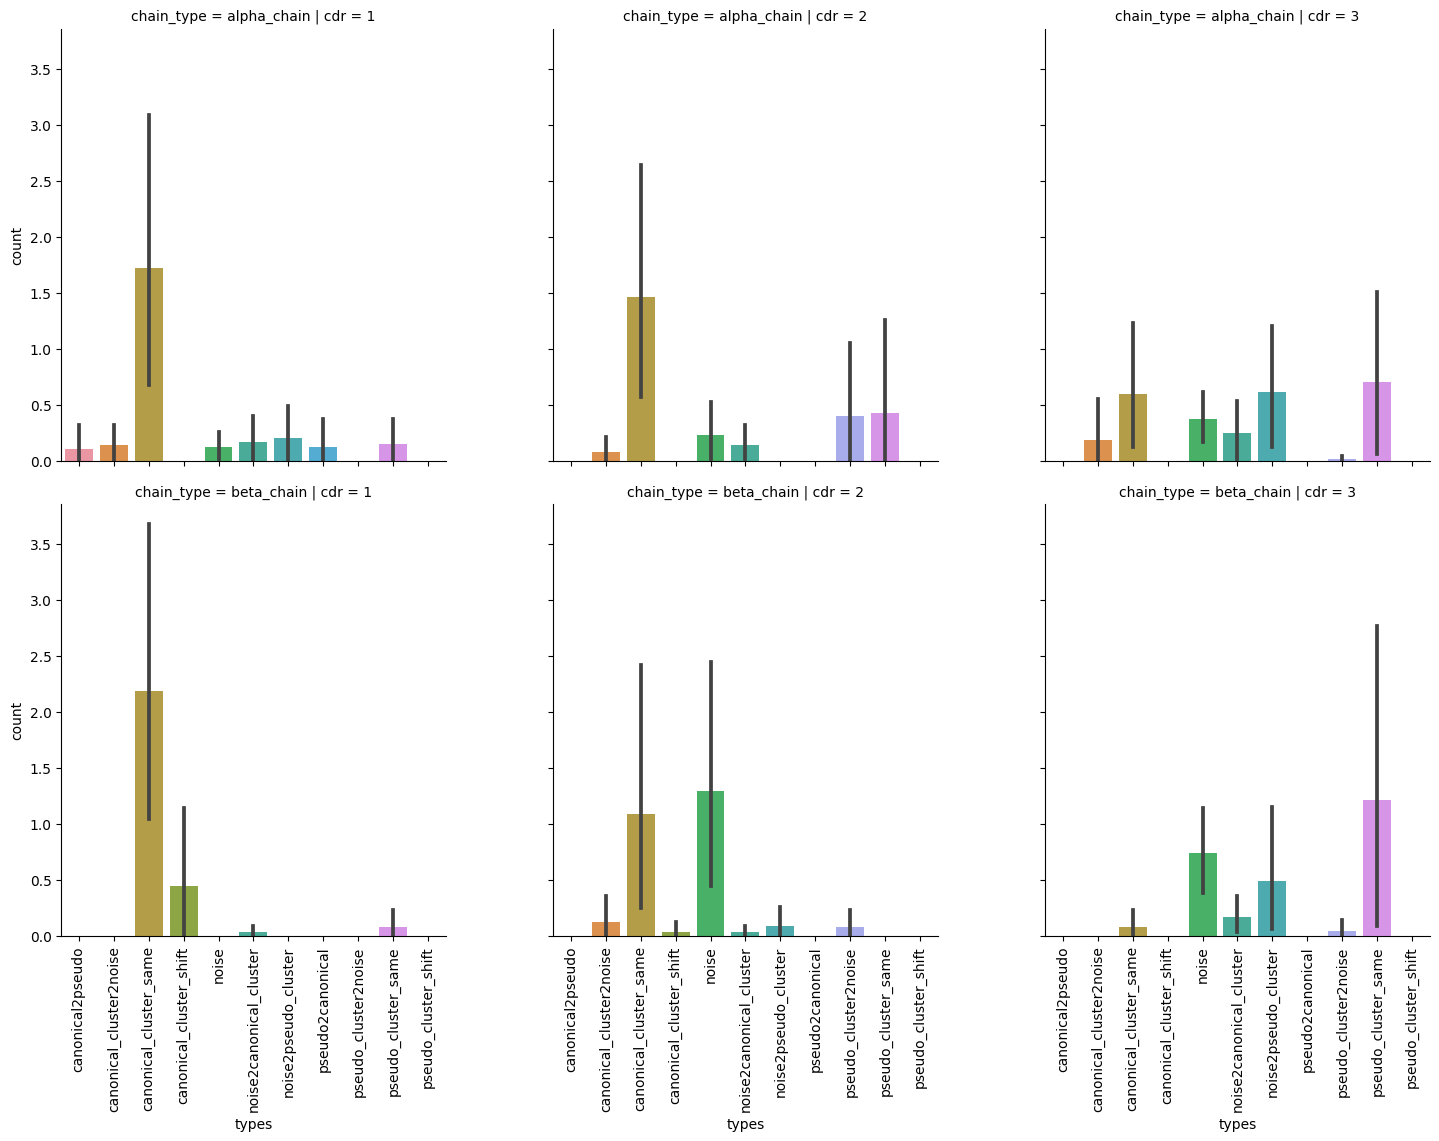

In [33]:
g = sns.catplot(apo_holo_clusters_agg.sort_values(['chain_type', 'cdr', 'types']),
                row='chain_type', col='cdr',
                x='types', y='count',
                kind='bar')

for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90)

plt.savefig('../report/figures/apo_holo_cluster_changes.svg')

In [34]:
cluster_shift_counts = apo_holo_clusters_agg.groupby(['chain_type', 'cdr', 'types'])['count'].sum().astype(int)
cluster_shift_counts[cluster_shift_counts > 0]

chain_type   cdr  types                  
alpha_chain  1    canonical2pseudo             7
                  canonical_cluster2noise      9
                  canonical_cluster_same     112
                  noise                        8
                  noise2canonical_cluster     11
                  noise2pseudo_cluster        13
                  pseudo2canonical             8
                  pseudo_cluster_same         10
             2    canonical_cluster2noise      5
                  canonical_cluster_same      95
                  noise                       15
                  noise2canonical_cluster      9
                  pseudo_cluster2noise        26
                  pseudo_cluster_same         28
             3    canonical_cluster2noise     12
                  canonical_cluster_same      39
                  noise                       24
                  noise2canonical_cluster     16
                  noise2pseudo_cluster        40
                  pseudo_cl

In [35]:
export_cluster_shift_counts = cluster_shift_counts.to_frame().reset_index()

export_cluster_shift_counts = export_cluster_shift_counts.rename({'types': 'Movement Type'}, axis='columns')

export_cluster_shift_counts['CDR Type'] = export_cluster_shift_counts.apply(
    lambda row: f"CDR-{'A' if row.chain_type == 'alpha_chain' else 'B'}{row.cdr}",
    axis='columns',
)

export_cluster_shift_counts = export_cluster_shift_counts.pivot(index='Movement Type',
                                                                columns='CDR Type',
                                                                values='count')
export_cluster_shift_counts = export_cluster_shift_counts.sort_values('Movement Type')

export_cluster_shift_counts = export_cluster_shift_counts.replace(0, '-')

with open('../report/cluster_changes.tex', 'w') as fh:
    fh.write(export_cluster_shift_counts.to_latex())

export_cluster_shift_counts

/var/scratch/bmcmaste/1648454/ipykernel_2174483/3578552351.py:18: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



CDR Type                CDR-A1 CDR-A2 CDR-A3 CDR-B1 CDR-B2 CDR-B3
Movement Type                                                    
canonical2pseudo             7      -      -      -      -      -
canonical_cluster2noise      9      5     12      -      8      -
canonical_cluster_same     112     95     39    142     71      5
canonical_cluster_shift      -      -      -     29      2      -
noise                        8     15     24      -     84     48
noise2canonical_cluster     11      9     16      2      2     11
noise2pseudo_cluster        13      -     40      -      6     32
pseudo2canonical             8      -      -      -      -      -
pseudo_cluster2noise         -     26      1      -      5      3
pseudo_cluster_same         10     28     46      5      -     79
pseudo_cluster_shift         -      -      -      -      -      -

# Conclusion

The analysis here shows that for the most part, the CDR-1s and CDR-2s stay in their canonical forms between *apo* and *holo* states where as the CDR-3 loops have a variety of modes.
As expected, it is more difficult to cluster the CDR-3 loops as they are more structurally diverse.